## Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import re
import math
from sklearn import tree, ensemble, preprocessing, model_selection, neural_network
from sklearn.tree import export_graphviz
from subprocess import call
from dtreeviz.trees import dtreeviz 

## Auxiliary functions

In [2]:
def is_int_or_nan(x) -> bool:
    """
    Check if a string can be converted to int
    :param x: str to be checked
    :return: Boolean
    """
    if isinstance(x, float):
        if math.isnan(x):
            return True
    if x[0] in ("-", "+"):
        return x[1:].isdigit()
    return x.isdigit()


def type_change(column: pd.Series) -> pd.Series:
    """
    Checks if column can be parsed to int or float, and converts them.
    If column name ends with date, then string is converted to datetime.
    :param column: column to be converted
    :return: converted column
    """
    try:
        numeric = column.astype(float)
    except ValueError:
        # if column type is Object (string)
        return column
    
    if np.all(column.apply(is_int_or_nan)):
        return numeric.astype(int)
    else:
        return numeric


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each column, checks if the column can be parsed to int or float, and converts it.
    If column name ends with date, then string is converted to datetime.
    :param df: dataframe to be converted
    :return: converted dataframe
    """
    return df.apply(type_change, axis=0)


## Reading data to environment
We start with reading the csv file to a DataFrame and cleaning the data. Then we automatically change the type of the columns to numerical if needed.

In [3]:
data = pd.read_csv('acceleration_data.csv' ,sep = ',' , quoting =3).replace('"','', regex=True).reset_index(drop=True)
data.columns=[re.sub('\"','',c,) for c in data.columns]
data.rename(columns={'ID':'LONGITUDE','GEO':'LATITUDE'}, inplace=True)
data = data.apply(lambda x: x.str.strip(), axis=0)
data['EXP_CEO'] = data['EXP_CEO'].replace('NA', '0')
data = preprocess(data)
data['FLAG'] = data['FLAG'].apply(lambda x: 'BANKRUPT' if x>0 else 'SOLVENT')
data

,LONGITUDE,LATITUDE,SECTOR,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,FLAG
0,21.001716,52.231406,PUB,2,150426.0,7964,0,-8.078335,1633,138,2010,0,32,0,19950,SOLVENT
1,21.006869,52.233266,PUB,6,500078.0,30212,0,17.032851,6128,605,2011,0,44,1,45104,BANKRUPT
2,21.074607,52.279005,IT,27,199767.0,4970,0,-7.321621,487,106,2005,0,83,0,499,SOLVENT
3,21.012082,52.232082,IT,5,109200.0,7010,1,1.135431,661,116,2011,0,21,1,0,BANKRUPT
4,21.000125,52.239957,IT,3,112200.0,9000,0,0.950873,926,172,2012,5,23,0,-997,BANKRUPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21.024514,52.235975,IT,8,79900.0,8980,0,0.974774,888,180,2012,0,18,2,2004,BANKRUPT
9996,21.018647,52.231323,IT,19,336500.0,23940,0,4.389039,2383,496,2006,0,202,5,0,BANKRUPT
9997,21.066010,52.295597,IT,3,200265.0,4981,1,-4.523559,502,109,2002,5,74,1,499,SOLVENT
9998,21.084683,52.275659,IT,30,199951.0,4957,1,-3.898251,532,101,2001,6,76,0,1000,BANKRUPT


The algorithm that we will use below, require all variables to be numerical. Therefore, we must convert the `Sector` variable to numerical. We will apply one hot encoding - it will delete `SECTOR` column and add 4 new columns - `PUB`, `IT`, `CAFE` and `RESTAURANT`. Each of these columns is equal to 1 if `SECTOR` is equal to the column name, and 0 otherwise.

In [4]:
encoder = preprocessing.OneHotEncoder() 
sector = encoder.fit_transform(data[['SECTOR']])
data = pd.concat([data, pd.DataFrame(sector.todense(),columns = encoder.categories_[0])],axis=1)
data = data.drop(columns='SECTOR')
data

,LONGITUDE,LATITUDE,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,FLAG,CAFE,IT,PUB,RESTAURANT
0,21.001716,52.231406,2,150426.0,7964,0,-8.078335,1633,138,2010,0,32,0,19950,SOLVENT,0.0,0.0,1.0,0.0
1,21.006869,52.233266,6,500078.0,30212,0,17.032851,6128,605,2011,0,44,1,45104,BANKRUPT,0.0,0.0,1.0,0.0
2,21.074607,52.279005,27,199767.0,4970,0,-7.321621,487,106,2005,0,83,0,499,SOLVENT,0.0,1.0,0.0,0.0
3,21.012082,52.232082,5,109200.0,7010,1,1.135431,661,116,2011,0,21,1,0,BANKRUPT,0.0,1.0,0.0,0.0
4,21.000125,52.239957,3,112200.0,9000,0,0.950873,926,172,2012,5,23,0,-997,BANKRUPT,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21.024514,52.235975,8,79900.0,8980,0,0.974774,888,180,2012,0,18,2,2004,BANKRUPT,0.0,1.0,0.0,0.0
9996,21.018647,52.231323,19,336500.0,23940,0,4.389039,2383,496,2006,0,202,5,0,BANKRUPT,0.0,1.0,0.0,0.0
9997,21.066010,52.295597,3,200265.0,4981,1,-4.523559,502,109,2002,5,74,1,499,SOLVENT,0.0,1.0,0.0,0.0
9998,21.084683,52.275659,30,199951.0,4957,1,-3.898251,532,101,2001,6,76,0,1000,BANKRUPT,0.0,1.0,0.0,0.0


The next step is to split the data into test and training sets

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.drop(columns='FLAG'), data['FLAG'], test_size=0.3)

## Analysis

Statistical analysis helps with choosing the best model.

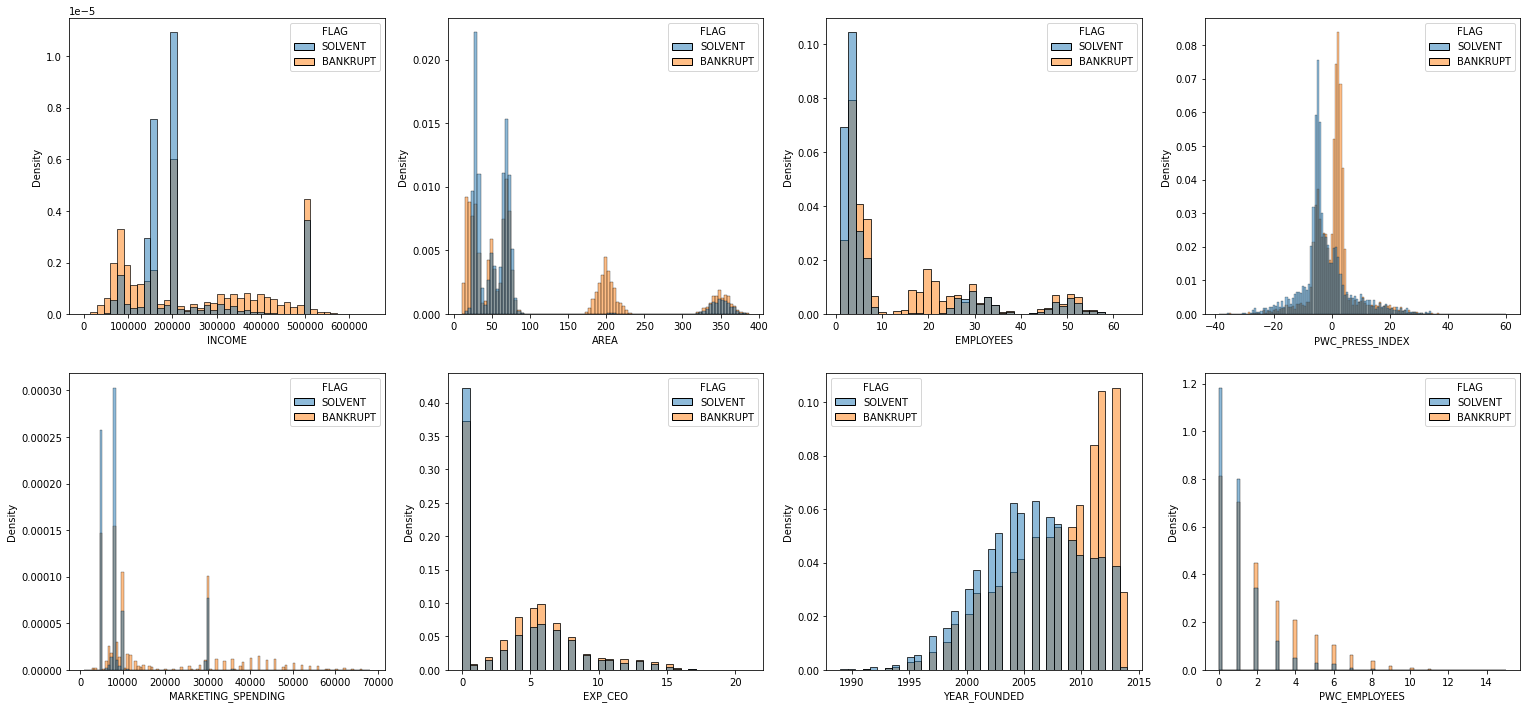

In [6]:
fig, axes = plt.subplots(2,4, figsize= (26, 12))
for i, var in enumerate(['INCOME', 'AREA', 'EMPLOYEES', 'PWC_PRESS_INDEX', 'MARKETING_SPENDING', 'EXP_CEO', 'YEAR_FOUNDED', 'PWC_EMPLOYEES']):
    sns.histplot(data, x=var, hue='FLAG', stat="density", ax=axes[i//4,i%4])

## Model training

We will use random forest as the classifier.

In [7]:
clf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=100).fit(X_train, y_train)

We can compare the estimated probabilities with the original data.

In [8]:
pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), pd.DataFrame(np.round(clf.predict_proba(X_test)[:,0],2), columns=['PROB_OF_BANKRUPTCY'])], axis=1)

,LONGITUDE,LATITUDE,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,EXP_CEO,AREA,PWC_EMPLOYEES,CREDIT,CAFE,IT,PUB,RESTAURANT,FLAG,PROB_OF_BANKRUPTCY
0,21.028775,52.235128,4,122300.0,7960,0,1.882356,728,148,2013,5,22,2,2004,0.0,1.0,0.0,0.0,SOLVENT,0.93
1,21.013293,52.233858,18,392000.0,62210,0,3.167145,6146,1214,2006,0,188,10,60009,0.0,1.0,0.0,0.0,BANKRUPT,0.97
2,21.068213,52.297381,3,199598.0,4963,1,-4.961909,497,90,2001,5,75,0,0,0.0,1.0,0.0,0.0,SOLVENT,0.04
3,21.025502,52.227779,6,60700.0,16040,0,1.979719,1593,293,2013,5,23,2,-2996,0.0,1.0,0.0,0.0,BANKRUPT,0.98
4,21.028861,52.239081,18,346750.0,36040,1,3.479736,3618,742,2009,6,208,9,59204,0.0,1.0,0.0,0.0,BANKRUPT,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,21.009808,52.233807,5,500545.0,30118,1,5.553624,6019,595,2012,0,50,0,20047,0.0,0.0,0.0,1.0,BANKRUPT,0.52
2996,21.033468,52.293647,1,160000.0,8106,1,-34.531618,1606,159,2007,7,29,1,21102,1.0,0.0,0.0,0.0,BANKRUPT,0.59
2997,21.036854,52.272779,30,199287.0,4901,1,-6.814890,503,108,2000,0,67,0,1206,0.0,1.0,0.0,0.0,SOLVENT,0.46
2998,21.016294,52.238334,22,452250.0,44140,0,4.693102,4249,928,2007,0,195,8,58816,0.0,1.0,0.0,0.0,BANKRUPT,0.99


## Assessment

If we assume, that company with probability more than 0.5 will fail, then the accuracy of our prediction is equal to:

In [9]:
np.mean(clf.predict(X_test) == y_test)

0.7636666666666667

We can compare how many companies are bankrupt vs the prediction.

In [10]:
pd.crosstab(clf.predict(X_test),y_test, rownames=['Prediction'], colnames=['Reality'])

Reality,BANKRUPT,SOLVENT
Prediction,,
BANKRUPT,1327,463
SOLVENT,246,964


Random trees also provide information about the importance of features.

In [11]:
pd.DataFrame({'importance (%)': np.round(clf.feature_importances_, 3)*100, 'feature': X_train.columns}).sort_values('importance (%)',ascending= False)

,importance (%),feature
3,10.9,INCOME
6,10.7,PWC_PRESS_INDEX
4,10.3,MARKETING_SPENDING
0,9.0,LONGITUDE
7,8.8,FB_LIKES
1,8.2,LATITUDE
11,8.1,AREA
2,7.3,EMPLOYEES
8,6.3,TWT_FOLLOWERS
9,4.9,YEAR_FOUNDED


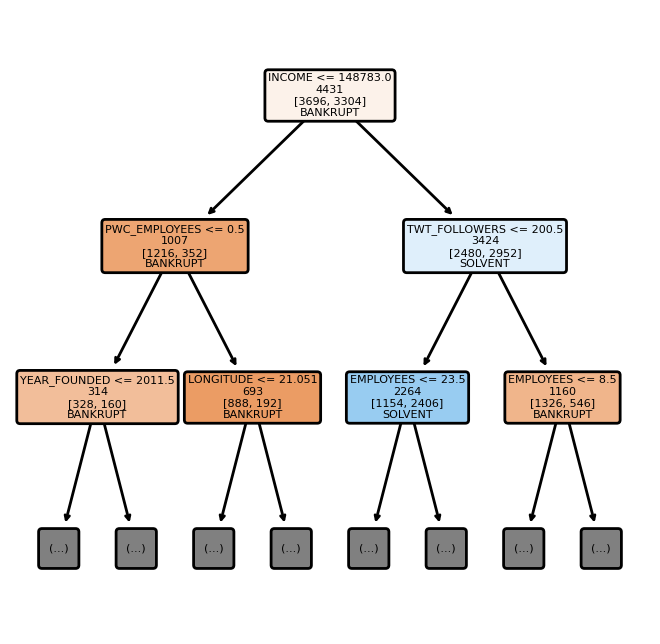

In [22]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
_ = tree.plot_tree(clf.estimators_[0],
               feature_names = X_train.columns, 
               class_names=clf.classes_,
               impurity=False,
               proportion=False,
               rounded=True,
               fontsize=4,
               label=None,
               filled = True, max_depth=2)